In [316]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('..', 'config'), 'donors_db_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

conn = connect()


import RecallAdjuster as ra
from importlib import reload
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import numpy as np

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


In [339]:
## FOR DONORS
### Train End Time is all end dates
base = datetime.datetime.strptime('2013-03-01', '%Y-%m-%d')   #Corresponding to latest train_end_time
date_pairs = []

# we can make x range to 20 months ago
for x in range(5, -1, -1):
    date_pairs.append(
        (
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d'),
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d'),
            (base - relativedelta(months=6*x)).strftime('%Y-%m-%d')
        )
    )

for i in range(0, len(date_pairs), 2):
    print(date_pairs[i], date_pairs[i+1])

('2010-03-01', '2010-03-01') ('2010-03-01', '2010-09-01')
('2010-09-01', '2010-09-01') ('2010-09-01', '2011-03-01')
('2011-03-01', '2011-03-01') ('2011-03-01', '2011-09-01')
('2011-09-01', '2011-09-01') ('2011-09-01', '2012-03-01')
('2012-03-01', '2012-03-01') ('2012-03-01', '2012-09-01')
('2012-09-01', '2012-09-01') ('2012-09-01', '2013-03-01')


In [340]:
## FOR DONORS
### Train End Time is all end dates
base = datetime.datetime.strptime('2013-03-01', '%Y-%m-%d')   #Corresponding to latest train_end_time
date_pairs = []

# we can make x range to 20 months ago
for x in range(5, -1, -1):
    date_pairs.append(
        (
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d'),
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
            (base - relativedelta(months=6*x) - relativedelta(months=6)).strftime('%Y-%m-%d'),
            (base - relativedelta(months=6*x)).strftime('%Y-%m-%d')
        )
    )

for i in range(0, len(date_pairs), 2):
    print(date_pairs[i], date_pairs[i+1])

('2010-03-01', '2010-03-01') ('2010-03-01', '2010-09-01')
('2010-09-01', '2010-09-01') ('2010-09-01', '2011-03-01')
('2011-03-01', '2011-03-01') ('2011-03-01', '2011-09-01')
('2011-09-01', '2011-09-01') ('2011-09-01', '2012-03-01')
('2012-03-01', '2012-03-01') ('2012-03-01', '2012-09-01')
('2012-09-01', '2012-09-01') ('2012-09-01', '2013-03-01')


147867 183912


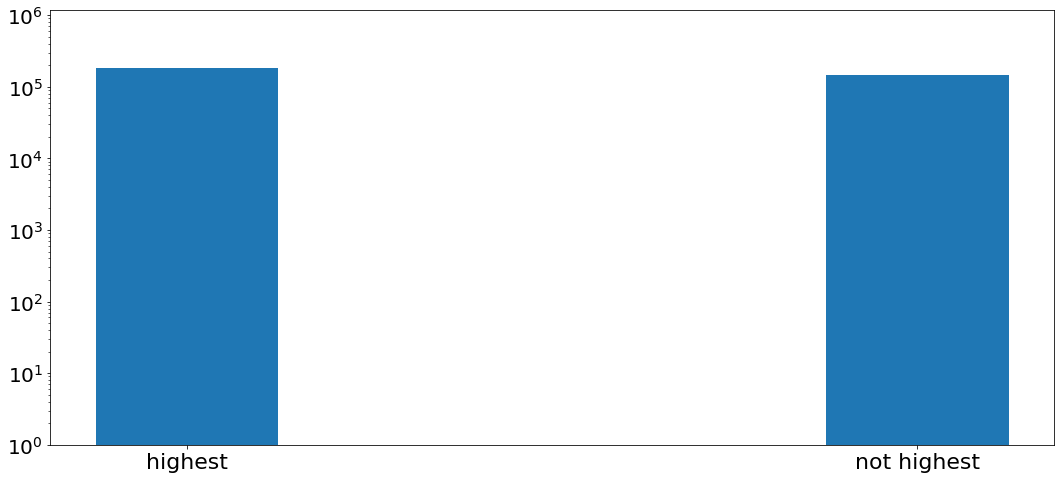

In [13]:
query = """
select plevel, count(*) as c from hemank_bias_2way.entity_demos
group by plevel
"""
df = pd.read_sql(query, conn)
poverty_levels = df['plevel'].values
counts = df['c'].values

mod_counts = [counts[0], counts[1]]
mod_plevel = ['highest', 'not_highest']
plt.figure(figsize=(18,8))
plt.bar(np.arange(len(mod_plevel)), mod_counts, width=0.25)

#plt.xticks(range(len(poverty_levels)), [str(pl).replace("_", " ") for pl in poverty_levels], fontsize=20)
plt.xticks(range(len(mod_plevel)), [str(pl).replace("_", " ") for pl in mod_plevel], fontsize=22)
plt.ylim([1, max(counts)+1000000])
plt.yscale('log')
plt.yticks(fontsize=20)

print(min(counts), max(counts))

In [341]:
import time
start_time = time.time()
myRA = ra.RecallAdjuster(
        engine=conn,
        pg_role='hemank',
        schema='hemank_bias_2way',
        experiment_hashes='18c35f3a3ba8c0ff9457a911b3bb7e1a',
        date_pairs=date_pairs,
        list_sizes=[1000, 2500, 5000, 7500, 10000],
        entity_demos='donors',
        demo_col='plevel'
)
print("Time Taken="+str(time.time() - start_time))

Setting demo values. Not using pre-set values
Not running subsampling OR bootstrap based models
Time Taken=1492.779590845108


Date Pair: ('2012-09-01', '2013-03-01')
List Size: 10000
Metric: precision@10000_abs


{'highest_to_not_highest': <matplotlib.axes._subplots.AxesSubplot at 0x7fd5b9e41d30>,
 'not_highest_to_highest': <matplotlib.axes._subplots.AxesSubplot at 0x7fd5b9fb7c18>}

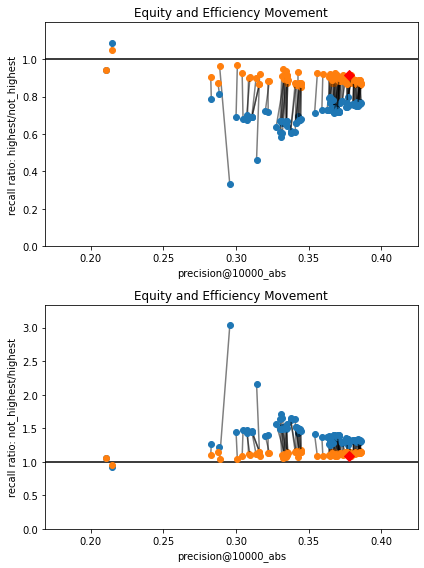

In [342]:
myRA.plot(recall_ratio='all_demos')

Date Pair: ('2012-09-01', '2013-03-01')
List Size: 5000
Metric: precision@5000_abs


<Figure size 720x576 with 0 Axes>

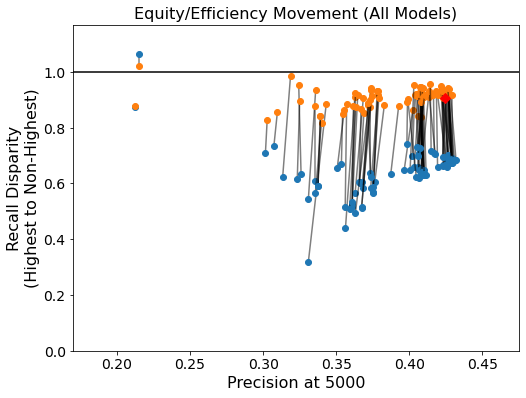

In [343]:
plt.figure(figsize=(10,8))
axd = myRA.plot(recall_ratio='highest_to_not_highest', list_size=5000)
#axd['highest_to_not_highest'].set_ylim((1.0,1.14))
#axd['highest_to_not_highest'].set_xlim([0.205, 0.210])
axd['highest_to_not_highest'].set_xlabel('Precision at 5000', fontsize=16)
axd['highest_to_not_highest'].set_ylabel('Recall Disparity\n(Highest to Non-Highest)', fontsize=16)
axd['highest_to_not_highest'].set_title('Equity/Efficiency Movement (All Models)', fontsize=16)
axd['highest_to_not_highest'].tick_params(axis='x', labelsize=14)
axd['highest_to_not_highest'].tick_params(axis='y', labelsize=14)
axd['highest_to_not_highest'].figure.set_figwidth(8)
axd['highest_to_not_highest'].figure.set_figheight(6)

Date Pair: ('2012-09-01', '2013-03-01')
List Size: 5000
Metric: precision@5000_abs


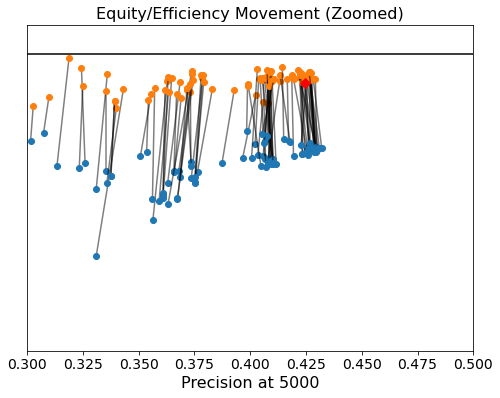

In [344]:
axd = myRA.plot(recall_ratio='highest_to_not_highest', list_size=5000)
axd['highest_to_not_highest'].set_xlim((0.30,0.50))
axd['highest_to_not_highest'].set_ylim((0.0,1.10))
axd['highest_to_not_highest'].set_xlabel('Precision at 5000', fontsize=16)
axd['highest_to_not_highest'].set_ylabel('')
axd['highest_to_not_highest'].set_title('Equity/Efficiency Movement (Zoomed)', fontsize=16)
axd['highest_to_not_highest'].tick_params(axis='x', labelsize=14)
axd['highest_to_not_highest'].yaxis.set_ticks([])
axd['highest_to_not_highest'].figure.set_figwidth(8)
axd['highest_to_not_highest'].figure.set_figheight(6)

In [345]:
print(date_pairs)

[('2010-03-01', '2010-03-01'), ('2010-03-01', '2010-09-01'), ('2010-09-01', '2010-09-01'), ('2010-09-01', '2011-03-01'), ('2011-03-01', '2011-03-01'), ('2011-03-01', '2011-09-01'), ('2011-09-01', '2011-09-01'), ('2011-09-01', '2012-03-01'), ('2012-03-01', '2012-03-01'), ('2012-03-01', '2012-09-01'), ('2012-09-01', '2012-09-01'), ('2012-09-01', '2013-03-01')]


In [346]:
mvmt_df = myRA.adjustment_results.loc[(myRA.adjustment_results['list_size'] == 5000)
            & (myRA.adjustment_results['metric'] == 'precision@'),
            ['base_value', 'base_%s' % 'recall_highest_to_not_highest', 
             'adj_value', 'adj_%s' % 'recall_highest_to_not_highest']]

mvmt_df['delta_prec'] = mvmt_df['adj_value'] - mvmt_df['base_value']
mvmt_df.loc[mvmt_df['base_value'] > 0.5, ]['delta_prec'].describe()
mvmt_df['delta_prec'] = mvmt_df['adj_value'] - mvmt_df['base_value']
mvmt_df.loc[mvmt_df['base_value'] > 0.5, ].head()

,base_value,base_recall_highest_to_not_highest,adj_value,adj_recall_highest_to_not_highest,delta_prec
130,0.5166,0.232218,0.5310,1.000193,0.0144
131,0.5166,0.232218,0.5320,0.850819,0.0154
132,0.5166,0.232218,0.5310,1.000193,0.0144
133,0.5166,0.232218,0.5320,0.850819,0.0154
180,0.5394,0.304965,0.5506,0.818784,0.0112


In [347]:
mvmt_df.loc[mvmt_df['base_value'] > 0.5, ]['delta_prec'].describe()

count    340.000000
mean       0.000725
std        0.006462
min       -0.014200
25%       -0.003200
50%       -0.000200
75%        0.003400
max        0.022800
Name: delta_prec, dtype: float64

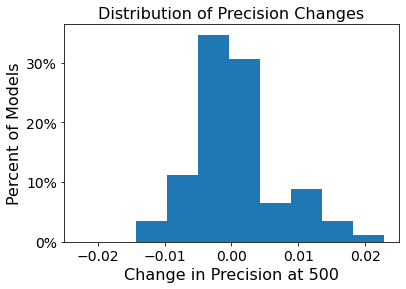

In [348]:
from matplotlib.ticker import PercentFormatter
import numpy as np

#print(np.sum(mvmt_df['base_value']>0.5))
ax = mvmt_df.loc[mvmt_df['base_value'] > 0.5,]['delta_prec'].plot.hist(bins=8, xlim=(-0.025,0.025), 
                                                                        weights=np.ones(340) / 340)

ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_title('Distribution of Precision Changes', fontsize=16)
ax.set_xlabel('Change in Precision at 500', fontsize=16)
ax.set_ylabel('Percent of Models', fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

## Selection Strategy

In [349]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([4,8,12])  # every month
months_fmt = mdates.DateFormatter('%b %y')

In [350]:
sql = """
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM hemank_bias_2way.model_adjustment_results_plevel
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)
-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_highest_to_not_highest AS recall_highest_to_not,
       r.base_recall_not_highest_to_highest AS recall_not_to_highest,
       r.base_frac_highest AS frac_highest,
       r.base_frac_not_highest AS frac_not_highest
FROM hemank_bias_2way.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_highest_to_not_highest AS recall_highest_to_not,
       r.adj_recall_not_highest_to_highest AS recall_not_to_highest,
       r.adj_frac_highest AS frac_highest,
       r.adj_frac_not_highest AS frac_not_highest
FROM hemank_bias_2way.model_adjustment_results_plevel r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_highest_to_not_highest AS recall_highest_to_not,
       r.adj_recall_not_highest_to_highest AS recall_not_to_highest,
       r.adj_frac_highest AS frac_highest,
       r.adj_frac_not_highest AS frac_not_highest
FROM hemank_bias_2way.model_adjustment_results_plevel r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL
-- Composite Model - Adjusted
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      r.train_end_time AS train_end_time,
      r.past_train_end_time AS past_train_end_time,
      r.list_size, metric, parameter,
      r.value AS value,
      r.max_recall_ratio AS max_recall_ratio,
      r.recall_highest_to_not_highest AS recall_highest_to_not,
      r.recall_not_highest_to_highest AS recall_not_to_highest,
      r.frac_highest AS frac_highest,
      r.frac_not_highest AS frac_not_highest
FROM hemank_bias_2way.composite_results_plevel r
WHERE train_end_time > past_train_end_time
"""
ts_df = pd.read_sql(sql, conn)

In [356]:
print(pd.value_counts(ts_df['train_end_time']))
print(pd.value_counts(ts_df[ts_df['train_end_time']>'2011-06-01']['train_end_time']))

2011-09-01    35
2012-03-01    35
2011-03-01    35
2012-09-01    35
2013-03-01    20
Name: train_end_time, dtype: int64
2011-09-01    35
2012-03-01    35
2012-09-01    35
2013-03-01    20
Name: train_end_time, dtype: int64


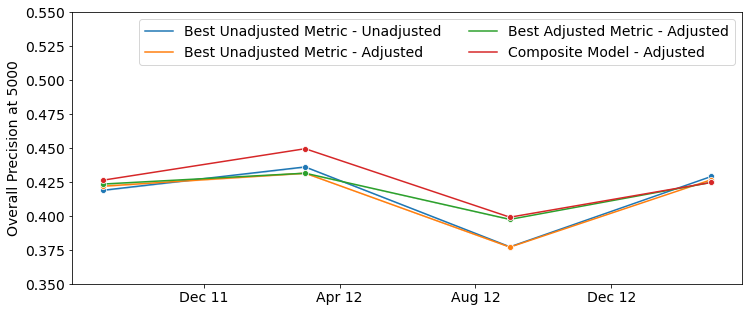

In [361]:
fig, ax = plt.subplots(figsize=(12,5))
ts_df_5k_sd = ts_df[(ts_df['list_size']==5000) & (ts_df['train_end_time']>'2011-06-01')]
sns.lineplot(data=ts_df_5k_sd, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax)

ax.set_ylim((0.35,0.55))
ax.set_ylabel('Overall Precision at 5000', fontsize=14)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=14)

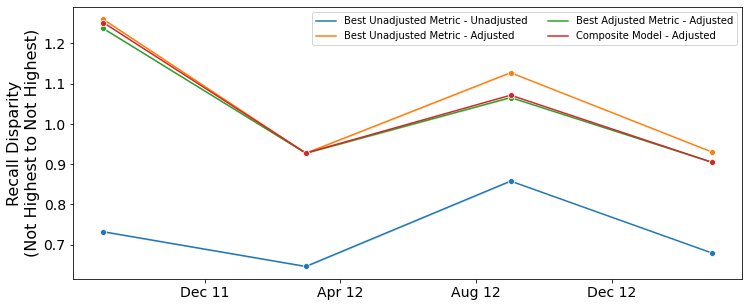

In [366]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_5k_sd, x='train_end_time', y='recall_highest_to_not', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity\n(Not Highest to Not Highest)', fontsize=16)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

#ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=10)

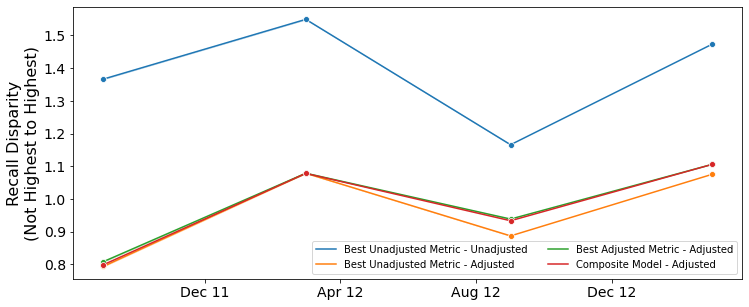

In [367]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_5k_sd, x='train_end_time', y='recall_not_to_highest', hue='strategy', marker="o", ax=ax)

ax.set_ylabel('Recall Disparity\n(Not Highest to Highest)', fontsize=16)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

#ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=2, fontsize=10)

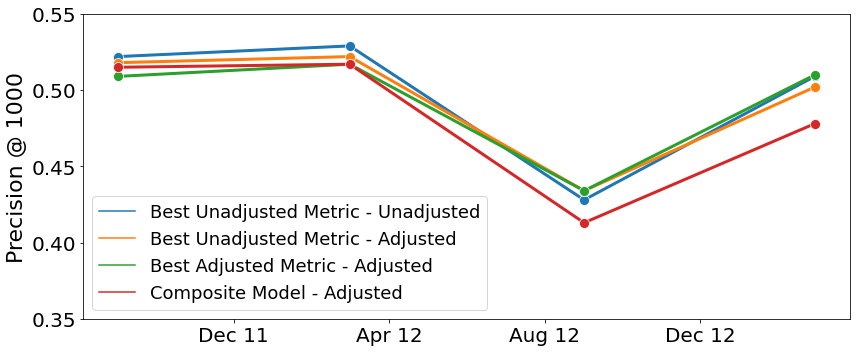

In [372]:
ts_df_1k_sd = ts_df[(ts_df['list_size']==1000) & (ts_df['train_end_time']>'2011-06-01')]
fig, ax = plt.subplots(figsize=(12,5))

sns.lineplot(data=ts_df_1k_sd, x='train_end_time', y='value', hue='strategy', marker="o", ax=ax, 
             linewidth=3.0, markersize=10)


ax.set_ylabel('Precision @ 1000', fontsize=22)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.set_ylim([0.35, 0.55])
handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=18, loc='lower left')
plt.tight_layout()
plt.savefig('../PLOTS/donors_choose_value_1k_over_time.pdf')

In [378]:
ts_df_1k_sd.groupby('strategy').describe()

list_size                               \
                                        count    mean  std     min     25%   
strategy                                                                     
Best Adjusted Metric - Adjusted           7.0  1000.0  0.0  1000.0  1000.0   
Best Unadjusted Metric - Adjusted         7.0  1000.0  0.0  1000.0  1000.0   
Best Unadjusted Metric - Unadjusted       7.0  1000.0  0.0  1000.0  1000.0   
Composite Model - Adjusted                4.0  1000.0  0.0  1000.0  1000.0   

                                                            value            \
                                        50%     75%     max count      mean   
strategy                                                                      
Best Adjusted Metric - Adjusted      1000.0  1000.0  1000.0   7.0  0.490000   
Best Unadjusted Metric - Adjusted    1000.0  1000.0  1000.0   7.0  0.492857   
Best Unadjusted Metric - Unadjusted  1000.0  1000.0  1000.0   7.0  0.495286   
Composite Model - Adjusted           1000.0  1000.0  1000.0   4.0  0.480750   

                                                                               \
                                          std    min      25%     50%     75%   
strategy                                                                        
Best Adjusted Metric - Adjusted      0.038410  0.434  0.47150  0.5090  0.5135   
Best Unadjusted Metric - Adjusted    0.040773  0.434  0.46800  0.5180  0.5200   
Best Unadjusted Metric - Unadjusted  0.046446  0.428  0.46850  0.5220  0.5255   
Composite Model - Adjusted           0.048596  0.413  0.46175  0.4965  0.5155   

                                           max_recall_ratio            \
                                       max            count      mean   
strategy                                                                
Best Adjusted Metric - Adjusted      0.517              7.0  1.119969   
Best Unadjusted Metric - Adjusted    0.522              7.0  1.101757   
Best Unadjusted Metric - Unadjusted  0.529              7.0  1.572405   
Composite Model - Adjusted           0.517              4.0  1.143847   

                                                                             \
                                          std       min       25%       50%   
strategy                                                                      
Best Adjusted Metric - Adjusted      0.089085  1.013931  1.078224  1.090042   
Best Unadjusted Metric - Adjusted    0.082181  1.017005  1.042000  1.090042   
Best Unadjusted Metric - Unadjusted  0.140078  1.422249  1.423360  1.673024   
Composite Model - Adjusted           0.114427  1.018272  1.063236  1.148074   

                                                        recall_highest_to_not  \
                                          75%       max                 count   
strategy                                                                        
Best Adjusted Metric - Adjusted      1.167351  1.244660                   7.0   
Best Unadjusted Metric - Adjusted    1.152824  1.215607                   7.0   
Best Unadjusted Metric - Unadjusted  1.684466  1.695909                   7.0   
Composite Model - Adjusted           1.228685  1.260969                   4.0   

                                                                             \
                                         mean       std       min       25%   
strategy                                                                      
Best Adjusted Metric - Adjusted      1.076891  0.132456  0.927451  0.970691   
Best Unadjusted Metric - Adjusted    1.078241  0.107915  0.959693  0.988349   
Best Unadjusted Metric - Unadjusted  0.640427  0.058388  0.589654  0.593687   
Composite Model - Adjusted           1.106154  0.159288  0.927451  0.995566   

                                                                   \
                                          50%       75%       max   
strategy                                 

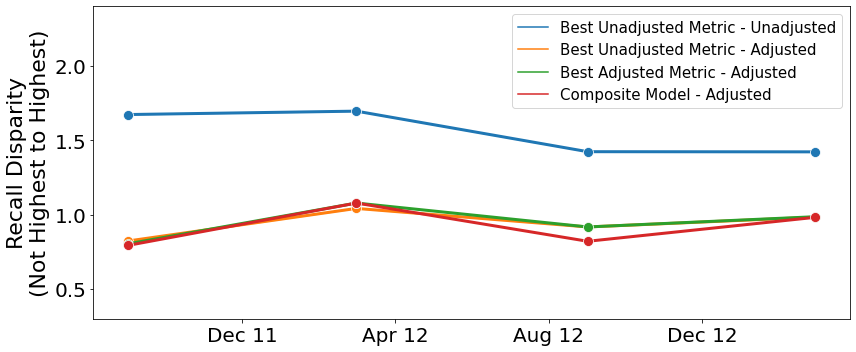

In [385]:
fig, ax = plt.subplots(figsize=(12,5))

sns.lineplot(data=ts_df_1k_sd, x='train_end_time', y='recall_not_to_highest', hue='strategy', marker="o", ax=ax, 
             linewidth=3.0, markersize=10)


ax.set_ylabel('Recall Disparity\n(Not Highest to Highest)', fontsize=22)
ax.set_xlabel('')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

#ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, ncol=1, fontsize=15, loc='upper right')
ax.set_ylim([0.3,2.4])
plt.tight_layout()
plt.savefig('../PLOTS/donors_choose_recall_1k_over_time.pdf')

## List Size

In [410]:
mod_ts_df = ts_df[((ts_df['list_size']==1000) | (ts_df['list_size']==2500) |
                  (ts_df['list_size']==5000) | (ts_df['list_size']==7500) | 
                  (ts_df['list_size']==10000)) & (ts_df['train_end_time']>'2011-06-01')]

#mod_ts_df = ts_df[ts_df['train_end_time']>'2011-06-01']
#mod_ts_df.groupby('strategy').describe()
mod_ts_df

,strategy,train_end_time,past_train_end_time,list_size,metric,parameter,value,max_recall_ratio,recall_highest_to_not,recall_not_to_highest,frac_highest,frac_not_highest
2,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,2500,precision@,2500_abs,0.466400,1.534278,0.651772,1.534278,0.381200,0.618800
3,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,2500,precision@,2500_abs,0.466400,1.534278,0.651772,1.534278,0.381200,0.618800
4,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,1000,precision@,1000_abs,0.522000,1.673024,0.597720,1.673024,0.385000,0.615000
5,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,1000,precision@,1000_abs,0.522000,1.673024,0.597720,1.673024,0.385000,0.615000
6,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,7500,precision@,7500_abs,0.394933,1.400515,0.714023,1.400515,0.414400,0.585600
7,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,7500,precision@,7500_abs,0.394933,1.400515,0.714023,1.400515,0.414400,0.585600
8,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,10000,precision@,10000_abs,0.377800,1.339273,0.746674,1.339273,0.423000,0.577000
9,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,10000,precision@,10000_abs,0.377800,1.339273,0.746674,1.339273,0.423000,0.577000
10,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,5000,precision@,5000_abs,0.418800,1.366547,0.731771,1.366547,0.422000,0.578000
11,Best Unadjusted Metric - Unadjusted,2011-09-01,2011-03-01,5000,precision@,5000_abs,0.418800,1.366547,0.731771,1.366547,0.422000,0.578000


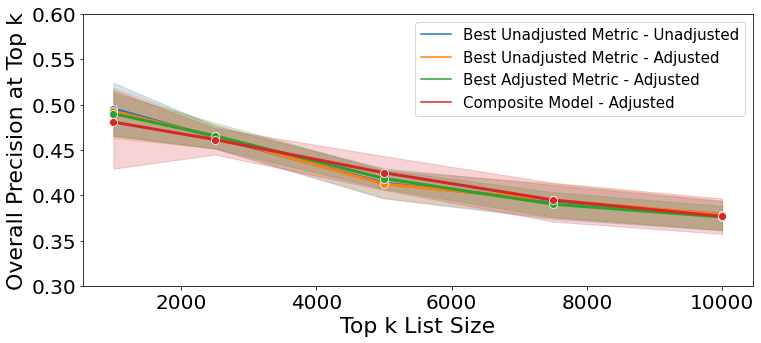

In [411]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=mod_ts_df, x='list_size', y='value', hue='strategy', marker="o", ax=ax, 
             linewidth=3, markersize=8)

ax.set_ylabel('Overall Precision at Top k', fontsize=22)
ax.set_xlabel('Top k List Size', fontsize=22)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, fontsize=15)
ax.set_ylim([0.3, 0.6])
plt.savefig('../PLOTS/donors_choose_1k_list_size.pdf')

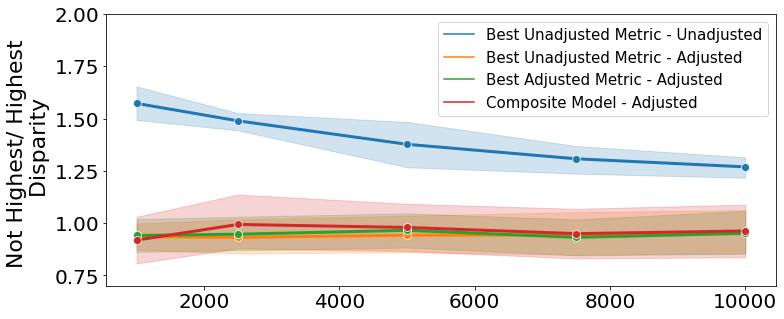

In [415]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=mod_ts_df, x='list_size', y='recall_not_to_highest', hue='strategy', marker="o", ax=ax, 
             linewidth=3, markersize=8)

ax.set_ylabel('Not Highest/ Highest \n Disparity', fontsize=22)
ax.set_xlabel('')

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax.set_ylim([0.7, 2.0])

#ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.legend(hhandles, llabels, fontsize=15, loc='upper right')
plt.savefig('../PLOTS/donors_choose_1k_recall_highest.pdf')

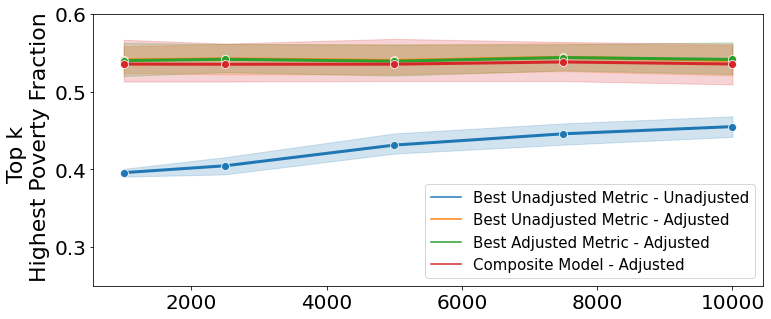

In [413]:
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=mod_ts_df, x='list_size', y='frac_highest', hue='strategy', marker="o", ax=ax, 
             linewidth=3, markersize=8)

ax.set_ylabel('Top k \n Highest Poverty Fraction', fontsize=22)
ax.set_xlabel('')

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

handles, labels = ax.get_legend_handles_labels()
hhandles = []
llabels = []
for i, lab in enumerate(labels):
    if lab not in ('strategy'):
        llabels.append(lab)
        hhandles.append(handles[i])
ax.set_ylim([0.25,0.6])
ax.legend(hhandles, llabels, fontsize=15, loc='lower right')
plt.savefig('../PLOTS/donors_choose_1k_highest_frac.pdf')

In [211]:
ts_df.groupby(['strategy'])[['value', 'recall_highest_to_not']].describe()

value                              \
                                    count      mean       std     min   
strategy                                                                
Best Adjusted Metric - Adjusted      45.0  0.483719  0.090620  0.3811   
Best Unadjusted Metric - Adjusted    45.0  0.483753  0.089439  0.3874   
Best Unadjusted Metric - Unadjusted  45.0  0.484294  0.089995  0.3918   

                                                                     \
                                          25%     50%    75%    max   
strategy                                                              
Best Adjusted Metric - Adjusted      0.412800  0.4446  0.548  0.723   
Best Unadjusted Metric - Adjusted    0.412800  0.4460  0.542  0.723   
Best Unadjusted Metric - Unadjusted  0.410667  0.4520  0.544  0.725   

                                    recall_highest_to_not                      \
                                                    count      mean       std   
strategy                                                                        
Best Adjusted Metric - Adjusted                      45.0  1.024269  0.203999   
Best Unadjusted Metric - Adjusted                    45.0  1.019659  0.202047   
Best Unadjusted Metric - Unadjusted                  45.0  0.668789  0.135067   

                                                                             \
                                          min       25%       50%       75%   
strategy                                                                      
Best Adjusted Metric - Adjusted      0.711985  0.882201  0.951566  1.216225   
Best Unadjusted Metric - Adjusted    0.711985  0.882201  0.945982  1.242213   
Best Unadjusted Metric - Unadjusted  0.395468  0.543967  0.720311  0.774614   

                                               
                                          max  
strategy                                       
Best Adjusted Metric - Adjusted      1.336519  
Best Unadjusted Metric - Adjusted    1.323526  
Best Unadjusted Metric - Unadjusted  0.853204

## Aggregated_Plot

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


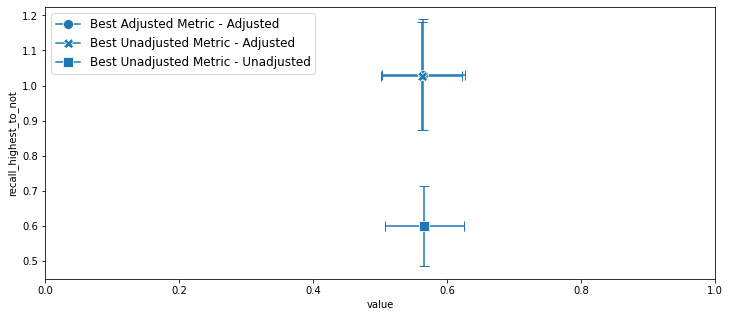

In [291]:
ts_df_1k['dataset'] = 'donors_choose'
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=ts_df_1k.groupby(['dataset', 'strategy'])[['value', 'recall_highest_to_not']].mean().reset_index(), 
              x='value', y='recall_highest_to_not', 
              hue='dataset', 
#              marker="o", 
              style='strategy',
              markers=True,
#              color='dodgerblue',
              markersize=10,
              dashes=None,
              ci=None,
              ax=ax)

x_coords = list(ts_df_1k.groupby(['dataset', 'strategy'])[['value', 'recall_highest_to_not']].mean().reset_index()['value'].values)
y_coords = list(ts_df_1k.groupby(['dataset', 'strategy'])[['value', 'recall_highest_to_not']].mean().reset_index()['recall_highest_to_not'].values)
labels = list(ts_df_1k.groupby(['dataset', 'strategy'])['strategy'].min())

prec_errors = 1.96*ts_df_1k.groupby(['dataset', 'strategy'])['value'].sem().values
disp_errors = 1.96*ts_df_1k.groupby(['dataset', 'strategy'])['recall_highest_to_not'].sem().values
colors = sns.color_palette().as_hex()[0]
ax.errorbar(x_coords, y_coords, 
            xerr=prec_errors, 
            yerr=disp_errors,
            ecolor=colors, 
            fmt=' ', zorder=-1, capsize=5)

ax.set_xlim((0.0,1.00))
ax.legend(labels, fontsize=12, loc='upper left')
plt.savefig('../PLOTS/donors_choose_delta_value_recall.pdf')

In [285]:
labels = list(ts_df_1k.groupby(['dataset', 'strategy'])['strategy'].min())
print(labels)

['Best Adjusted Metric - Adjusted', 'Best Unadjusted Metric - Adjusted', 'Best Unadjusted Metric - Unadjusted']


In [229]:
ts_df_1k.groupby(['dataset', 'strategy'])[['value', 'recall_highest_to_not']].mean().reset_index()

,dataset,strategy,value,recall_highest_to_not
0,donors_choose,Best Adjusted Metric - Adjusted,0.564556,1.031015
1,donors_choose,Best Unadjusted Metric - Adjusted,0.562222,1.026530
2,donors_choose,Best Unadjusted Metric - Unadjusted,0.566444,0.599621


In [230]:
ts_df_1k.groupby(['dataset', 'strategy'])[['value', 'recall_highest_to_not']].std().reset_index()

,dataset,strategy,value,recall_highest_to_not
0,donors_choose,Best Adjusted Metric - Adjusted,0.094657,0.241210
1,donors_choose,Best Unadjusted Metric - Adjusted,0.092854,0.235427
2,donors_choose,Best Unadjusted Metric - Unadjusted,0.091106,0.176315


In [232]:
ts_df.groupby(['dataset','strategy'])[['value', 'recall_highest_to_not']].describe()

value                      \
                                                  count      mean       std   
dataset       strategy                                                        
donors_choose Best Adjusted Metric - Adjusted      45.0  0.483719  0.090620   
              Best Unadjusted Metric - Adjusted    45.0  0.483753  0.089439   
              Best Unadjusted Metric - Unadjusted  45.0  0.484294  0.089995   

                                                                             \
                                                      min       25%     50%   
dataset       strategy                                                        
donors_choose Best Adjusted Metric - Adjusted      0.3811  0.412800  0.4446   
              Best Unadjusted Metric - Adjusted    0.3874  0.412800  0.4460   
              Best Unadjusted Metric - Unadjusted  0.3918  0.410667  0.4520   

                                                                 \
                                                     75%    max   
dataset       strategy                                            
donors_choose Best Adjusted Metric - Adjusted      0.548  0.723   
              Best Unadjusted Metric - Adjusted    0.542  0.723   
              Best Unadjusted Metric - Unadjusted  0.544  0.725   

                                                  recall_highest_to_not  \
                                                                  count   
dataset       strategy                                                    
donors_choose Best Adjusted Metric - Adjusted                      45.0   
              Best Unadjusted Metric - Adjusted                    45.0   
              Best Unadjusted Metric - Unadjusted                  45.0   

                                                                       \
                                                       mean       std   
dataset       strategy                                                  
donors_choose Best Adjusted Metric - Adjusted      1.024269  0.203999   
              Best Unadjusted Metric - Adjusted    1.019659  0.202047   
              Best Unadjusted Metric - Unadjusted  0.668789  0.135067   

                                                                       \
                                                        min       25%   
dataset       strategy                                                  
donors_choose Best Adjusted Metric - Adjusted      0.711985  0.882201   
              Best Unadjusted Metric - Adjusted    0.711985  0.882201   
              Best Unadjusted Metric - Unadjusted  0.395468  0.543967   

                                                                       \
                                                        50%       75%   
dataset       strategy                                                  
donors_choose Best Adjusted Metric - Adjusted      0.951566  1.216225   
              Best Unadjusted Metric - Adjusted    0.945982  1.242213   
              Best Unadjusted Metric - Unadjusted  0.720311  0.774614   

                                                             
                                                        max  
dataset       strategy                                       
donors_choose Best Adjusted Metric - Adjusted      1.336519  
              Best Unadjusted Metric - Adjusted    1.323526  
              Best Unadjusted Metric - Unadjusted  0.853204